In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)
print(torch.version.cuda)


cuda
2.0.1+cu118
11.8


In [2]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [3]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=2):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()

        y = self.avg_pool(x).view(batch_size, num_channels)

        y = self.fc1(y)
        y = self.relu(y)

        y = self.fc2(y)
        y = self.sigmoid(y)

        y = y.view(batch_size, num_channels, 1, 1)
        return x * y

class SpecNetWithSE(nn.Module):
    def __init__(self, in_channels=1):
        super(SpecNetWithSE, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, 
                               kernel_size=3, stride=1, padding=0)
        self.batch1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.se_block1 = SEBlock(8)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, 
                               kernel_size=3, stride=1, padding=0)
        self.batch2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.se_block2 = SEBlock(16)
       
        self.fc = nn.Linear(46656, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        
        x = self.se_block1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)
        
        x = self.se_block2(x)

        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        x = torch.sigmoid(x)
        return x

In [4]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=2):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()

        y = self.avg_pool(x).view(batch_size, num_channels)

        y = self.fc1(y)
        y = self.relu(y)

        y = self.fc2(y)
        y = self.sigmoid(y)

        y = y.view(batch_size, num_channels, 1, 1)
        return x * y

class SpecNetWithSE(nn.Module):
    def __init__(self, in_channels=1):
        super(SpecNetWithSE, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, 
                               kernel_size=6, stride=1, padding=2)
        self.batch1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        
        self.se_block1 = SEBlock(8)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, 
                               kernel_size=6, stride=1, padding=2)
        self.batch2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        
        self.se_block2 = SEBlock(16)
       
        self.fc = nn.Linear(9216, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        
        x = self.se_block1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)
        
        x = self.se_block2(x)

        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        x = torch.sigmoid(x)
        return x

In [5]:
class SpecNet(nn.Module):
    def __init__(self):
        super(SpecNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, 
                               kernel_size=3, stride=1, padding=0)
        self.batch1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, 
                               kernel_size=3, stride=1, padding=0)
        self.batch2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
       
        self.fc = nn.Linear(46656, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)

        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        x = torch.sigmoid(x)
        return x

In [6]:
class SpectrogramDataset(Dataset):
    def __init__(self, paths_to_spectrograms, transform):
        self.paths_to_spectrograms = paths_to_spectrograms
        self.transform = transform
        self.patient_spectrograms = {}
        self.patient_labels = {}

        for path in paths_to_spectrograms:
            spec_path, label = path.split(' ')
            patient_id = os.path.splitext(os.path.basename(spec_path))[0]
            patient_id = patient_id.split('_')[0]
            
            if patient_id not in self.patient_labels:
                self.patient_labels[patient_id] = int(label)
            
            if patient_id not in self.patient_spectrograms:
                self.patient_spectrograms[patient_id] = []
            self.patient_spectrograms[patient_id].append(spec_path)
    
    def __len__(self):
        return len(self.patient_spectrograms)

    def __getitem__(self, idx):

        patient_id = list(self.patient_spectrograms.keys())[idx]
        spectrogram_path = self.patient_spectrograms[patient_id]
        
        spectrogram = Image.open(spectrogram_path[0]).convert('L')
        
        if self.transform:
            spectrogram = self.transform(spectrogram)
            
        spectrogram = torch.tensor(np.array(spectrogram), dtype=torch.float32)
        
        spectrogram = spectrogram / 255.0 
        
        label = self.patient_labels[patient_id]
        spectrogram = spectrogram.unsqueeze(0)
        
        return spectrogram, label



In [7]:
file_paths = []
patients_ids = []
file_name = 'combined_paths/dataset_HC_a.txt'

with open(file_name, 'r') as file:
    for line in file:
        if 'log' in line:
            file_paths.append(line.strip())

with open(file_name, 'r') as file:
    for line in file:
        spec_path, label = line.split(' ')
        patient_id = os.path.splitext(os.path.basename(spec_path))[0]
        patient_id = patient_id.split('_')[0]
        if patient_id not in patients_ids:
            patients_ids.append(patient_id)

print(file_paths)
print(patients_ids)

['HC_a\\healthy\\10_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\11_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\12_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\130_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\131_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\132_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\133_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\134_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\135_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\136_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\137_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\138_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\139_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\13_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\140_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\141_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\142_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\143_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\144_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\145_a_log_mel_spectrogram.png 0', 'HC

In [11]:
import cv2

class InfoHolder():

    def __init__(self, heatmap_layer):
        self.gradient = None
        self.activation = None
        self.heatmap_layer = heatmap_layer

    def get_gradient(self, grad):
        self.gradient = grad

    def hook(self, model, input, output):
        output.register_hook(self.get_gradient)
        self.activation = output.detach()

def generate_heatmap(weighted_activation):
    raw_heatmap = torch.mean(weighted_activation, 0)
    heatmap = np.maximum(raw_heatmap.detach().cpu(), 0)
    heatmap /= torch.max(heatmap) + 1e-10
    return heatmap.numpy()

def superimpose(input_img, heatmap):
    img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * 0.6 + img * 0.4)
    pil_img = cv2.cvtColor(superimposed_img,cv2.COLOR_BGR2RGB)
    return pil_img

def to_RGB(tensor):
    tensor = (tensor - tensor.min())
    tensor = tensor/(tensor.max() + 1e-10)
    image_binary = np.transpose(tensor.numpy(), (1, 2, 0))
    image = np.uint8(255 * image_binary)
    return image

def grad_cam(model, input_tensor, heatmap_layer, truelabel=None):
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    
    output = model(input_tensor.to(device).unsqueeze(0))[0]
    truelabel = truelabel if truelabel else torch.argmax(output)

    output[truelabel].backward()

    weights = torch.mean(info.gradient, [0, 2, 3])
    activation = info.activation.squeeze(0)

    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = weight * activation

    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]]) tensor([1])
Sample 1 - Patient ID: 10 - Label: 0
torch.Size([1, 1, 224, 224])


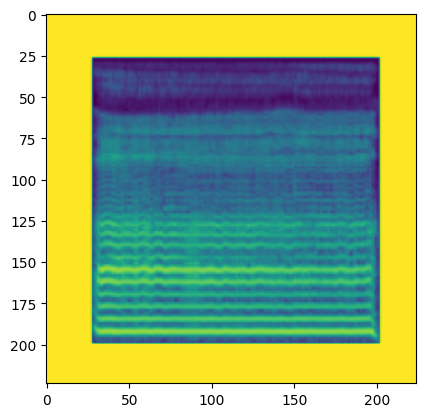

In [74]:
transform = transforms.Compose([
    transforms.Resize((224, 224))
])

dataset = SpectrogramDataset(file_paths, transform)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for i, (data, label) in enumerate(dataloader):
    print(data, label)
    patient_id = list(dataset.patient_spectrograms.keys())[i]
    patient_label = dataset.patient_labels.get(patient_id, None)
    print(f"Sample {i + 1} - Patient ID: {patient_id} - Label: {patient_label}")
    num_spectrograms = data.shape[0]
    img = data[i].numpy()
    print(data.shape)
    img = img.transpose(1, 2, 0)
    plt.imshow(img)
    plt.show()
    if i == 0:
        break

(224, 224)
(224, 224, 3)


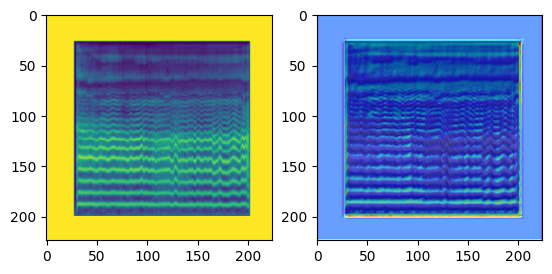

In [132]:
PATH = 'saved models/HC_SpecNet_a.pt'
model = torch.load(PATH)
model.eval()

spectrogram = Image.open('HC_a\\healthy\\11_a_log_mel_spectrogram.png').convert('L')
spectrogram = Image.open('HC_a\\ill\\61_a_log_mel_spectrogram.png').convert('L')
        

spectrogram = transform(spectrogram)
    
spectrogram = torch.tensor(np.array(spectrogram), dtype=torch.float32)

spectrogram = spectrogram / 255.0 

spectrogram = spectrogram.unsqueeze(0)

img = spectrogram[0].numpy()
print(img.shape)

plt.subplot(1, 2, 1)

plt.imshow(img)

plt.subplot(1, 2, 2)
heatmap_layer = model.se_block1

image = grad_cam(model, spectrogram, heatmap_layer, 1)
print(image.shape)
plt.imshow(image[:, :, :])

plt.show()

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224))
])

acc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

acc_scores_2 = []
f1_scores_2 = []
precision_scores_2 = []
recall_scores_2 = []


num_epochs = 50
num_splits = 5 
kf = KFold(n_splits=num_splits, shuffle=True, random_state=37)

def get_patient_id(file):
    spec_path, label = file.split(' ')
    patient_id = os.path.splitext(os.path.basename(spec_path))[0]
    patient_id = patient_id.split('_')[0]

    return patient_id

for fold, (train_idx, val_idx) in enumerate(kf.split(patients_ids)):
    print(f"Fold {fold + 1}/{num_splits}")

    train_patients = np.array(patients_ids)[train_idx]
    val_patients = np.array(patients_ids)[val_idx]

    train_files = [file for file in file_paths if get_patient_id(file) in train_patients]
    val_files = [file for file in file_paths if get_patient_id(file) in val_patients]


    train_dataset = SpectrogramDataset(train_files, transform)
    val_dataset = SpectrogramDataset(val_files, transform)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = SpecNetWithSE().to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = to_device(inputs, device), to_device(labels, device)

            optimizer.zero_grad()

            outputs = model(inputs)
            target = labels
            num_classes = 2

            target_one_hot = torch.zeros(target.size(0), num_classes, device=device)
            target_one_hot.scatter_(1, target.unsqueeze(1), 1)

            loss = criterion(outputs, target_one_hot.float())

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {total_loss / len(train_loader)}")

    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = to_device(inputs, device), to_device(labels, device)
            
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    f1_2 = f1_score(all_labels, all_predicted)
    precision_2 = precision_score(all_labels, all_predicted)
    recall_2 = recall_score(all_labels, all_predicted)
    accuracy_2 = correct / total

    f1 = f1_score(labels.cpu(), predicted.cpu())
    precision = precision_score(labels.cpu(), predicted.cpu())
    recall = recall_score(labels.cpu(), predicted.cpu())
    accuracy = correct / total
    
    print(f'Fold {fold + 1} Accuracy: {100 * correct / total:.2f}%, F1-score: {f1}, Precision: {precision}, Recall: {recall}')

    acc_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)

    acc_scores_2.append(accuracy_2)
    f1_scores_2.append(f1_2)
    precision_scores_2.append(precision_2)
    recall_scores_2.append(recall_2)

mean_acc = sum(acc_scores) / len(acc_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)
mean_precision = sum(precision_scores) / len(precision_scores)
mean_recall = sum(recall_scores) / len(recall_scores)

std_acc = np.std(mean_acc)
std_f1 = np.std(f1_scores)
std_precision = np.std(precision_scores)
std_recall = np.std(recall_scores)

print(f'Mean Accuracy: {mean_acc:.2f} (±{std_acc:.2f})')
print(f'Mean F1 Score: {mean_f1:.2f} (±{std_f1:.2f})')
print(f'Mean Precision: {mean_precision:.2f} (±{std_precision:.2f})')
print(f'Mean Recall: {mean_recall:.2f} (±{std_recall:.2f})')

mean_acc_2 = sum(acc_scores_2) / len(acc_scores_2)
mean_f1_2 = sum(f1_scores_2) / len(f1_scores_2)
mean_precision_2 = sum(precision_scores_2) / len(precision_scores_2)
mean_recall_2 = sum(recall_scores_2) / len(recall_scores_2)

std_acc_2 = np.std(mean_acc_2)
std_f1_2 = np.std(f1_scores_2)
std_precision_2 = np.std(precision_scores_2)
std_recall_2 = np.std(recall_scores_2)

print(f'Mean Accuracy_2: {mean_acc_2:.2f} (±{std_acc_2:.2f})')
print(f'Mean F1 Score_2: {mean_f1_2:.2f} (±{std_f1_2:.2f})')
print(f'Mean Precision_2: {mean_precision_2:.2f} (±{std_precision_2:.2f})')
print(f'Mean Recall_2: {mean_recall_2:.2f} (±{std_recall_2:.2f})')


Fold 1/5
Epoch [1/50] - Loss: 0.921394536892573
Epoch [2/50] - Loss: 0.7419714132944742
Epoch [3/50] - Loss: 0.6546507378419241
Epoch [4/50] - Loss: 0.6221319933732351
Epoch [5/50] - Loss: 0.5151135424772898
Epoch [6/50] - Loss: 0.44912178814411163
Epoch [7/50] - Loss: 0.40208666026592255
Epoch [8/50] - Loss: 0.41143227616945904
Epoch [9/50] - Loss: 0.3663831502199173
Epoch [10/50] - Loss: 0.3710092306137085
Epoch [11/50] - Loss: 0.32959510882695514
Epoch [12/50] - Loss: 0.3002754921714465
Epoch [13/50] - Loss: 0.2883349110682805
Epoch [14/50] - Loss: 0.2740352625648181
Epoch [15/50] - Loss: 0.26155055314302444
Epoch [16/50] - Loss: 0.281865822772185
Epoch [17/50] - Loss: 0.23027223348617554
Epoch [18/50] - Loss: 0.23479202141364416
Epoch [19/50] - Loss: 0.2772422358393669
Epoch [20/50] - Loss: 0.2552213470141093
Epoch [21/50] - Loss: 0.2207189823190371
Epoch [22/50] - Loss: 0.1960612734158834
Epoch [23/50] - Loss: 0.18995955338080725
Epoch [24/50] - Loss: 0.1878477856516838
Epoch [25/

In [50]:
output_file = f'single_spec_HC_SpecNet_{file_name}'

with open(output_file, 'w') as results:
    results.write(f'Mean Accuracy: {mean_acc:.2f} (±{std_acc:.2f}) \n')
    results.write(f'Mean F1 Score: {mean_f1:.2f} (±{std_f1:.2f}) \n')
    results.write(f'Mean Precision: {mean_precision:.2f} (±{std_precision:.2f}) \n')
    results.write(f'Mean Recall: {mean_recall:.2f} (±{std_recall:.2f}) \n')
    results.write(f'Mean Accuracy_2: {mean_acc_2:.2f} (±{std_acc_2:.2f}) \n')
    results.write(f'Mean F1 Score_2: {mean_f1_2:.2f} (±{std_f1_2:.2f}) \n')
    results.write(f'Mean Precision_2: {mean_precision_2:.2f} (±{std_precision_2:.2f}) \n')
    results.write(f'Mean Recall_2: {mean_recall_2:.2f} (±{std_recall_2:.2f}) \n')

In [10]:
PATH = f'single_spec_HC_SpecNet_a.pt'
torch.save(model, PATH)